# **Convertir data de campo a Shape y Raster**

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [30]:
# para pasar datos de csv a geodataframe.
import modules.data_gdf as data_gdf

In [31]:
data_media = data_gdf.data_gdf_media("data/datoshoy.txt")

c:\Users\Migue Polo\OneDrive - Universidad del Magdalena\SistemasInteligentes\kriging\modules\data_gdf.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_media = gdf.groupby("Muestra").mean()


In [114]:
data_media.to_file("data/data_media.shp")

C:\Users\Migue Polo\AppData\Local\Temp\ipykernel_34872\1783259303.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data_media.to_file("data/data_media.shp")


In [32]:
x = data_media["Longitud"]
y = data_media["Latitud"]
phi = data_media["Temperatura Suelo"]


In [3]:
phi

array([29.3, 21. , 19.2, 29.1, 21.9, 23.1])

Text(0.5, 1.0, 'Temperatura Suelo')

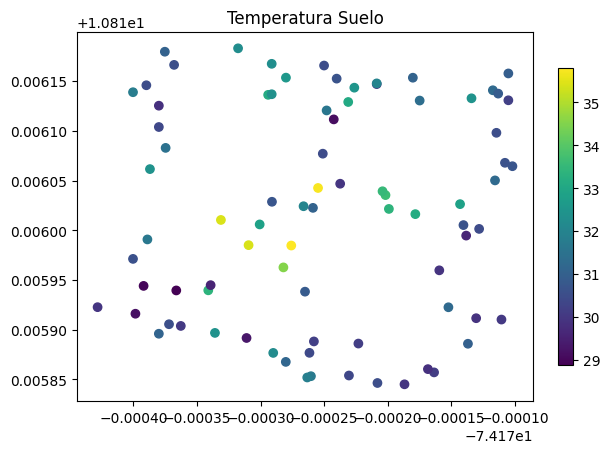

In [33]:
cax = plt.scatter(x, y, c=phi)
cbar = plt.colorbar(cax, fraction=0.03)
plt.title('Temperatura Suelo')


Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'hole-effect' Variogram Model
Partial Sill: 2.093418066052539
Full Sill: 2.093426385718599
Range: 0.00016035292595529565
Nugget: 8.319666059665576e-06 



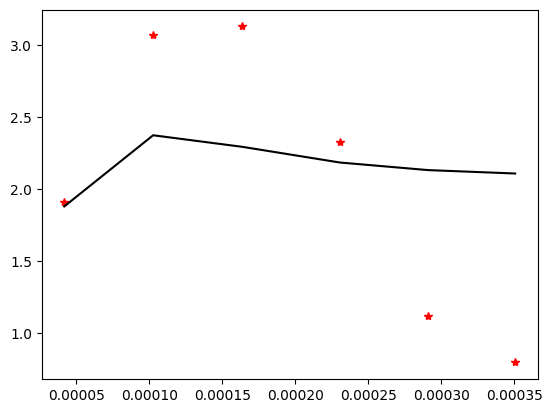

Calculating statistics on variogram model fit...


In [132]:
OK = OrdinaryKriging(
    x,
    y,
    phi,
    variogram_model="hole-effect",
    verbose=True,
    enable_plotting=True,
    coordinates_type='geographic',
    # nlags=30,
)


In [133]:
OK.variogram_model_parameters

array([2.09341807e+00, 1.60352926e-04, 8.31966606e-06])

In [134]:
# gridx = np.arange(-300, 300, 10, dtype='float64')
# gridy = np.arange(0, 600, 10, dtype='float64')
nx, ny = 100, 100
grid_x = np.linspace(min(x), max(x), nx)
grid_y = np.linspace(min(y), max(y), ny)
zstar, ss = OK.execute("grid", grid_x, grid_y)

Executing Ordinary Kriging...



In [135]:
print(zstar.shape)
print(ss.shape)

(100, 100)
(100, 100)


Text(0.5, 1.0, 'Temperatura del suelo')

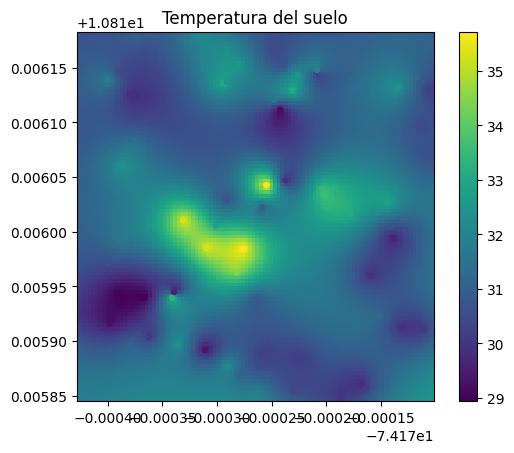

In [136]:
cax = plt.imshow(zstar, extent=(
    min(x), max(x), min(y), max(y)), origin='lower')
plt.scatter(x, y, c=phi, marker='.', s=50)
cbar = plt.colorbar(cax)
plt.title('Temperatura del suelo')


Text(0.5, 1.0, 'Desviación estándar')

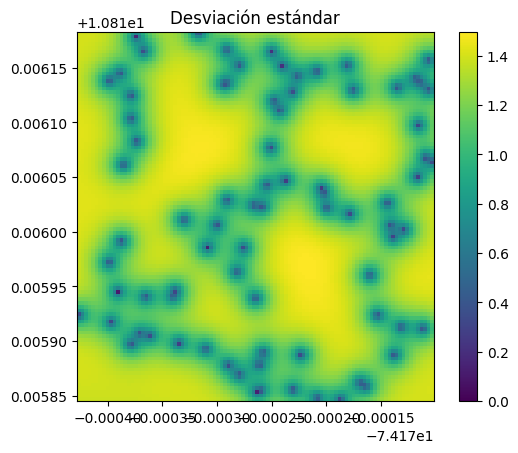

In [137]:
cax = plt.imshow(np.sqrt(ss), extent=(
    min(x), max(x), min(y), max(y)), origin='lower', vmin=0)
# plt.scatter(x, y, c='k', marker='.')
cbar = plt.colorbar(cax)
plt.title("Desviación estándar")


In [138]:
OK.variogram_model_parameters

array([2.09341807e+00, 1.60352926e-04, 8.31966606e-06])

Text(0.5, 1.0, 'Temperatura del suelo')

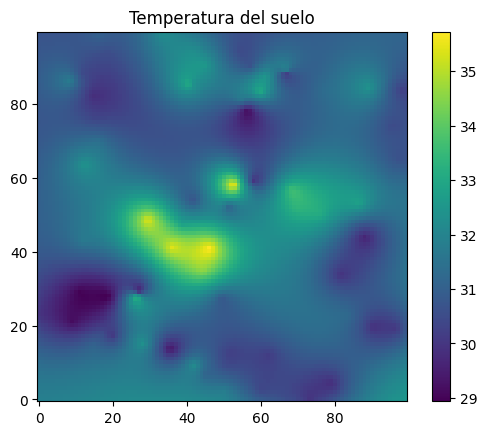

In [139]:
cax = plt.imshow(zstar, origin='lower')
cbar = plt.colorbar(cax)
plt.title('Temperatura del suelo')


In [140]:
import rasterio
from rasterio.transform import Affine


In [141]:
transform = rasterio.transform.from_bounds( 
    min(x), min(y), max(x), max(y), nx, ny)
transform


Affine(3.263999999916223e-06, 0.0, -74.17042819999999,
       0.0, -3.3800000000105966e-06, 10.816183)

In [143]:
with rasterio.open(
    'test2.tif',
    'w',
    driver='GTiff',
    height=zstar.shape[0],
    width=zstar.shape[1],
    count=1,
    dtype=zstar.dtype,
    crs={"init": "epsg:4326"},
    transform=transform,
) as dst:
    dst.write(zstar, 1)
